# Simple autoencoder for Tabula Sapiens dataset only
Apapted from the sample code provided along with the paper

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, BatchSampler, RandomSampler, random_split
from plotnine import *
from scvi.distributions import NegativeBinomial, Poisson, ZeroInflatedNegativeBinomial
from sklearn.metrics import r2_score, roc_auc_score, average_precision_score
import sys
import torch.nn as nn
import numpy as np
import pandas as pd
import scanpy as sc
from  torch.distributions.beta import Beta
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

from dataset import TS_Compressed_Dataset

/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/Users/zkm/miniforge3/envs/sheet5/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


In [2]:
#load the dataframe that contains one to one corresponding of gene id and gene index
gene_index = pd.read_csv("gene_index.csv")
path = "TabulaSapiens_CO_compressed.h5ad"

dataset = TS_Compressed_Dataset(gene_index, path)

In [3]:
device = torch.device("mps")

gene_list = gene_index.gene_id.to_list()
n_genes = len(gene_list) #the number of total genes 
emb_dim = 128 #the gene embedding dimension

NUM_LAYERS = 4 #the number decoder layers

assay_prior_log_sigma = float(0)

LEARNING_RATE = 0.001

EPOCHS = 9
BATCH_SIZE = int(1e5)

In [4]:
class GeneEmbedding(torch.nn.Module):
    def __init__(self, n_genes, emb_dim, gene_list, emb_init = None):
        super(GeneEmbedding, self).__init__()
        
        self.n_genes = n_genes
        self.emb_dim = emb_dim
        self.genes = gene_list
        
        """
        model the gene embedding as gaussian distributions computed from the mean embeddings and sd embeddings
        """
        if emb_init is not None:
            self.emb_mu = nn.Embedding.from_pretrained(emb_init, freeze = False)
        else:
            # init as [0, 1], as the dirichlet prior is in [0, 1]
            self.emb_mu = nn.Embedding.from_pretrained(
                torch.rand((n_genes, emb_dim)), freeze = False
            )
    
        self.emb_log_sigma = nn.Embedding.from_pretrained(
            torch.full((n_genes, emb_dim), np.log(0.5)), freeze = False
        )
    
    
    def get_emb_table(self):
        emb_df = pd.DataFrame(self.emb_mu.weight.detach().cpu(), 
                              index = self.genes,
                              columns = [f'FACT_EMB_{i}' for i in range(self.emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df
    
    
    def get_log_sigma_table(self):
        emb_df = pd.DataFrame(self.emb_log_sigma.weight.detach().cpu(), 
                              index = self.genes,
                              columns = [f'FACT_EMB_{i}' for i in range(self.emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df
    
    
    def get_shape(self):
        return (self.n_genes, self.emb_dim)
    


In [5]:
#initialize the gene embedding
gene_emb = GeneEmbedding(n_genes, 
                             emb_dim,  
                             gene_list, 
                             emb_init = torch.rand(n_genes, emb_dim) - 0.5,
                            )

In [6]:
#test the gene embedding
gene_emb.get_shape()
gene_emb.get_emb_table()

,FACT_EMB_0,FACT_EMB_1,FACT_EMB_2,FACT_EMB_3,FACT_EMB_4,FACT_EMB_5,FACT_EMB_6,FACT_EMB_7,FACT_EMB_8,FACT_EMB_9,...,FACT_EMB_118,FACT_EMB_119,FACT_EMB_120,FACT_EMB_121,FACT_EMB_122,FACT_EMB_123,FACT_EMB_124,FACT_EMB_125,FACT_EMB_126,FACT_EMB_127
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.276074,0.354034,-0.445649,-0.459395,-0.011212,0.167938,-0.474174,0.385111,-0.416867,0.474100,...,0.043499,0.093965,-0.197797,-0.094176,0.217798,-0.044039,-0.199145,0.269677,-0.485064,-0.134334
ENSG00000148584,0.240738,-0.142844,0.071939,-0.482863,-0.255614,0.435634,-0.245254,0.414282,0.422593,0.336843,...,-0.132865,0.215863,-0.070976,-0.266460,-0.262794,-0.303766,-0.490588,0.145752,-0.212755,-0.082336
ENSG00000175899,0.066675,0.430755,-0.274764,-0.023599,0.153130,0.133988,0.051452,0.265033,0.185678,0.364120,...,0.398927,0.400415,-0.392343,0.454202,-0.181210,0.469167,-0.367999,0.024601,-0.368396,-0.436148
ENSG00000166535,-0.450740,0.374223,-0.111069,-0.129471,0.269608,0.159659,-0.437359,0.263242,-0.277025,-0.011832,...,0.112650,-0.253347,0.313620,-0.389594,0.379396,0.058824,0.418515,-0.391997,0.344734,-0.199360
ENSG00000184389,0.177649,-0.343749,-0.073988,0.203930,0.088974,-0.236041,0.463429,-0.282865,0.453711,0.234314,...,-0.055871,0.380940,-0.164632,0.323322,0.414425,-0.173023,0.426937,0.376813,0.145224,-0.490338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000203995,0.102069,0.307946,0.234826,-0.358719,-0.008669,-0.421665,0.140853,-0.246806,-0.148294,-0.386252,...,-0.024996,0.241070,0.290623,-0.149880,-0.446580,0.053443,0.128467,0.197048,-0.171147,-0.216787
ENSG00000162378,0.161098,-0.187981,0.107935,0.179999,0.416212,0.101243,-0.155237,0.475658,0.192832,-0.066344,...,-0.314058,-0.010720,0.098892,0.427604,0.088109,0.253847,-0.123198,-0.107179,-0.126342,-0.040534
ENSG00000159840,0.442368,-0.335616,0.061573,0.178490,0.077047,0.327166,-0.001189,0.023042,0.168241,0.233393,...,-0.280586,0.379434,0.391257,0.100551,0.231871,0.496210,-0.496669,-0.253426,-0.490124,-0.040329


In [7]:
class AssayModel(torch.nn.Module):
    def __init__(self, gene_emb, sigma_init = np.log(0.5)):
        super().__init__()
        
        self.gene_emb = gene_emb
        
        
        self.assay_log_sigma = nn.Embedding.from_pretrained(
            torch.full(gene_emb.get_shape(), sigma_init), freeze = False
        )
        
        self.pass_assay_log_sigma = False
        
        
    def reparameterization(self, mean, sd):
        epsilon = torch.randn_like(sd)    # sampling epsilon        
        z = mean + sd * epsilon           # reparameterization trick
        return z


    # get mean log_sigma of the current assay without gradient. 
    def get_assay_log_sigma_mean(self, idx):
        with torch.no_grad():
            assay_log_sigma_mean = self.assay_log_sigma.weight.mean(axis = 1, keepdim = True)
            assay_log_sigma_mean = assay_log_sigma_mean[idx,:]
        return assay_log_sigma_mean
    
    def get_emb(self, idx):
        emb_mu = self.gene_emb.emb_mu.weight
        emb_sigma = self.gene_emb.emb_log_sigma.weight.exp()
        assay_sigma = self.assay_log_sigma.weight.exp()
        
         # replace the sampling twice by sampling only once using mu = mu_1 + mu_2 and sig^2 = sig_1^2 + sig_2^2
        sigma = torch.sqrt(emb_sigma.pow(2) + assay_sigma.pow(2))
        z_emb_assay = self.reparameterization(emb_mu[idx, :], sigma[idx, :])
        
        # add assay log sigma to embedding without gradient.
        if self.pass_assay_log_sigma is True:
            assay_log_sigma_mean = self.get_assay_log_sigma_mean(idx)
            z_emb_assay = torch.cat((z_emb_assay, assay_log_sigma_mean), dim = 1)
        return z_emb_assay
    
    
    def get_assay_log_sigma_table(self):
        emb_df = pd.DataFrame(self.assay_log_sigma.weight.detach().cpu(), 
                              index = self.gene_emb.genes,
                              columns = [f'FACT_EMB_{i}' for i in range(self.gene_emb.emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df

In [8]:
class TabluarDataModel(AssayModel):
    def __init__(self,  gene_emb, n_samples, emb_dim, sigma_init, pass_assay_log_sigma = False, emb_init = None):
        super().__init__(gene_emb, sigma_init)
            
        self.pass_assay_log_sigma = pass_assay_log_sigma
        
        #create sample embedding
        if emb_init is not None:
            self.sample_emb = nn.Embedding.from_pretrained(emb_init, freeze=False)
            #self.register_parameter("sample_emb",nn.Embedding.from_pretrained(emb_init, freeze=False))
        else:
            self.sample_emb = nn.Embedding(n_samples, emb_dim)
        
        joint_emb_dim = emb_dim + self.gene_emb.emb_dim
        var_model_dim = self.gene_emb.emb_dim
        
        if pass_assay_log_sigma is True:
            joint_emb_dim += 1
            var_model_dim += 1

        self.model = nn.Sequential()
        
        for i in range(NUM_LAYERS - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(joint_emb_dim, joint_emb_dim))
            self.model.add_module(f"relu_{i}", nn.ReLU())
        
        self.model.add_module(f"layer_{NUM_LAYERS - 1}", nn.Linear(joint_emb_dim, 1))
    
        
        self.var_model = nn.Sequential()
        
        for i in range(NUM_LAYERS - 1):
            self.var_model.add_module(f"layer_{i}", nn.Linear(var_model_dim, var_model_dim))
            self.var_model.add_module(f"relu_{i}", nn.ReLU())
        
        self.var_model.add_module(f"layer_{NUM_LAYERS - 1}", nn.Linear(var_model_dim, 1))
        # Init bias of last layer with small variance.
        nn.init.constant_(self.var_model[-1].bias, -2)
    
    #@torch.jit.script
    def forward(self, gene_index, sample_index):
        
        #get the gene embeddings and sample embeddings from indices
        gene_emb_batch = self.get_emb(gene_index)
        sample_emb_batch = self.sample_emb(sample_index)
        
        joint_emb = torch.cat((gene_emb_batch, sample_emb_batch), dim = 1)
        
        #use the joint embeddings to predict the score
        pred = self.model(joint_emb)
        #use the gene embeddings alone to predict the score???
        log_var = self.var_model(gene_emb_batch)
        # clip to avoid exp of log var to become inf or 0.
        log_var = log_var.clip(min=-40, max=40)
        
        return pred.squeeze(), log_var.squeeze()

    



In [9]:
class BaseLoss(nn.Module):
    def __init__(self, assay_prior_log_sigma):
        super(BaseLoss, self).__init__()
        
        self.assay_ls = torch.as_tensor(np.float32(assay_prior_log_sigma), device=device)
        self.emb_log_sigma_prior = torch.as_tensor(0., device=device)
        
        
    def compute_kl(self, model):
        
        loss_KLD_emb = kl_divergence(Normal(model.gene_emb.emb_mu.weight, model.gene_emb.emb_log_sigma.weight.exp()),
                                     Normal(0, self.emb_log_sigma_prior.exp())
                                     ).mean()
        loss_KLD_assay = kl_divergence(Normal(0, model.assay_log_sigma.weight.exp()),
                                       Normal(0, self.assay_ls.exp())
                                       ).mean()
        return loss_KLD_assay + loss_KLD_emb 



class MatLoss(BaseLoss):
    def __init__(self, assay_prior_log_sigma):
        super(MatLoss, self).__init__(assay_prior_log_sigma)
        
        self.mse_loss_mean = nn.MSELoss(reduction="mean")
        self.gnll = nn.GaussianNLLLoss(full=True, reduction='mean')
    
        
    def forward(self, pred_mu, pred_log_var, target, model):
           
        loss_NLL = self.gnll(pred_mu, target, torch.exp(pred_log_var))
        kl_term = self.compute_kl(model)
        
        return loss_NLL + kl_term, self.mse_loss_mean(pred_mu, target), loss_NLL #, loss_KLD_emb + loss_KLD_assay


In [10]:
#initilize the model
model= TabluarDataModel(gene_emb, 
                        n_samples = dataset.dataset["sample_idx"].unique().shape[0], 
                        emb_dim = 128,
                        sigma_init = assay_prior_log_sigma,
                        emb_init = torch.from_numpy(dataset.compute_sample_init_pca().astype('float32')),
                        )

loss = MatLoss(assay_prior_log_sigma)

opt = torch.optim.Adam(model.parameters(), 
                         lr = LEARNING_RATE,
                        )

In [11]:
dataset.test_table

sample_idx,gene_id,score,gene_idx
i64,str,f32,i64
96,"""ENSG0000012935…",-0.027678,809
12,"""ENSG0000010451…",0.229265,18177
67,"""ENSG0000016414…",-0.026871,939
18,"""ENSG0000014109…",-0.027682,4695
89,"""ENSG0000015472…",-0.02542,8152
168,"""ENSG0000017448…",-0.027691,9043
160,"""ENSG0000008050…",-0.021289,15623
0,"""ENSG0000007118…",0.176875,15803
71,"""ENSG0000018602…",-0.02762,19233


In [12]:
torch.from_numpy(np.array(dataset.test_table["gene_idx"]))

tensor([  809, 18177,   939,  ..., 18564, 13888, 14340])

In [13]:
def train_epoch(model, opt, loss_func, dataset):
    for g_idx, s_idx, target in dataset.get_batches(BATCH_SIZE, 'train'):
            
        model.to(device)
        
        opt.zero_grad()
        mu, log_var = model(g_idx.to(device, non_blocking=True), s_idx.to(device, non_blocking=True))
        target = target.to(device, non_blocking=True)
        elbo, mse, nll = loss_func(mu, log_var, target, model)           
            
        # sum losses, temporarily use the elbo
        loss = elbo
        loss.backward()
        opt.step()
            
           
                        
    opt.zero_grad(set_to_none=True)
    torch.mps.empty_cache()
    
    
    #compute the r2score on the test data
    with torch.no_grad():
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["sample_idx"]))
        test_target = torch.from_numpy(np.array(dataset.test_table["score"]))
        mu, log_var = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
        val_pred = mu.detach().cpu().numpy()
        val_target = test_target.detach().cpu().numpy()
    """
    val_pred = []
    val_target = []
    with torch.no_grad():
             for g_idx, s_idx, target in dataset.get_batches(BATCH_SIZE, 'test'):
                    mu, log_var = model(g_idx.to(device, non_blocking=True), s_idx.to(device, non_blocking=True))
                    target = target.to(device, non_blocking=True)
                    elbo, mse, nll = loss_func(mu, 
                                               log_var, 
                                               target,
                                               model
                                               )

                    val_pred.append(mu.detach().cpu().numpy())
                    val_target.append(target.detach().cpu().numpy())
                

    ## compute r2
    val_pred = np.concatenate(val_pred)
    val_target = np.concatenate(val_target)
    """
    r2 = r2_score(val_target, val_pred)
    return r2
        
     
        
    
        



In [14]:
r2=[]
for i in range(EPOCHS):
    print(i)
    r2.append(train_epoch(model, opt, loss, dataset))


0
1
2
3
4
5
6
7
8


In [15]:
r2

[-0.002391144760822028,
 0.008309084259399468,
 0.008720863261615142,
 0.008844690026313606,
 0.008282769250334554,
 0.008398309730779485,
 0.008284043961761411,
 0.007897154033751796,
 0.008025808589593453]

In [16]:
with torch.no_grad():
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["sample_idx"]))
        test_target = torch.from_numpy(np.array(dataset.test_table["score"]))
        mu, log_var = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
        val_pred = mu.detach().cpu().numpy()
        val_target = test_target.detach().cpu().numpy()

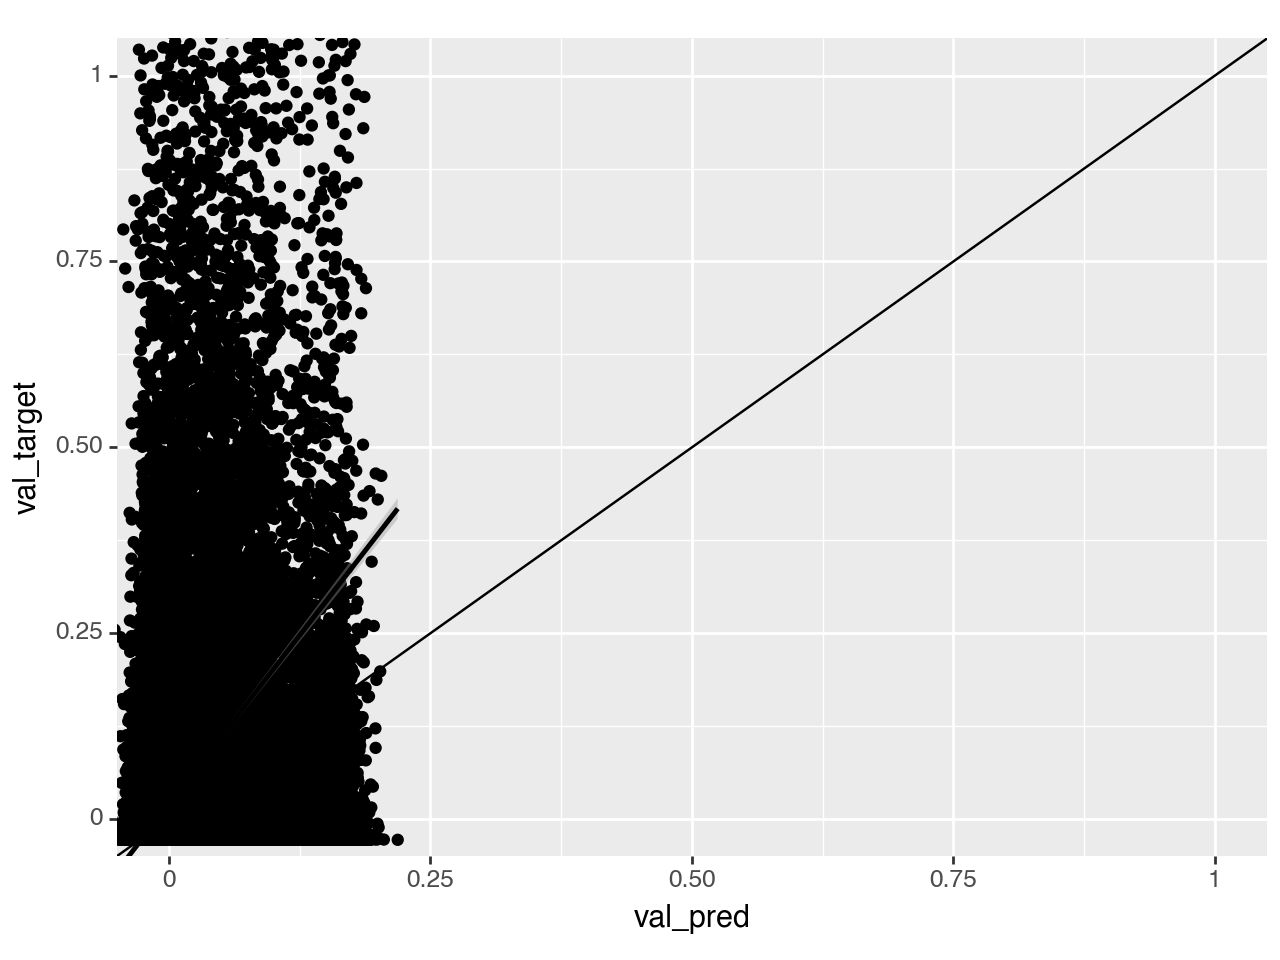

<Figure Size: (640 x 480)>

In [20]:
result = pd.DataFrame({
    "val_pred": val_pred,
    "val_target": val_target})
plot = ggplot(result) 
plot += geom_point(aes("val_pred", "val_target")) 
plot += coord_cartesian(ylim=(0, 1), xlim=(0,1))
plot += geom_smooth(aes("val_pred", "val_target"))
plot += geom_abline(intercept = 0, slope = 1)
plot 

In [18]:
gene_emb.get_emb_table()

,FACT_EMB_0,FACT_EMB_1,FACT_EMB_2,FACT_EMB_3,FACT_EMB_4,FACT_EMB_5,FACT_EMB_6,FACT_EMB_7,FACT_EMB_8,FACT_EMB_9,...,FACT_EMB_118,FACT_EMB_119,FACT_EMB_120,FACT_EMB_121,FACT_EMB_122,FACT_EMB_123,FACT_EMB_124,FACT_EMB_125,FACT_EMB_126,FACT_EMB_127
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.205582,0.611785,-0.616845,-0.408468,-0.312627,-0.125754,-0.696876,0.007277,-0.417823,0.119213,...,0.234167,-0.076742,0.029342,0.195621,-0.061118,-0.247303,-0.425195,-0.117264,-0.737774,-0.391222
ENSG00000148584,0.235701,0.191938,-0.172367,-0.448952,-0.526120,0.148559,-0.449455,0.044575,0.246936,0.041204,...,0.087943,0.021248,0.139613,0.019795,-0.482614,-0.452864,-0.631742,-0.226673,-0.504793,-0.326040
ENSG00000175899,0.063708,0.357024,-0.189704,-0.015152,0.216522,0.197325,0.128384,0.336785,0.207944,0.393638,...,0.342560,0.439249,-0.416725,0.378641,-0.098656,0.483728,-0.332039,0.106471,-0.291803,-0.357020
ENSG00000166535,-0.310324,0.569707,-0.335324,-0.142026,0.015246,-0.037624,-0.652337,-0.060066,-0.235976,-0.198569,...,0.272278,-0.441241,0.482558,-0.228411,0.143723,-0.161033,0.107101,-0.620403,0.057858,-0.378810
ENSG00000184389,0.169095,0.010149,-0.298947,0.136184,-0.218289,-0.486444,0.202268,-0.561912,0.241498,-0.047000,...,0.130355,0.138839,0.084418,0.527391,0.117500,-0.335894,0.118564,-0.005878,-0.199429,-0.715289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000203995,0.130494,0.570536,-0.020523,-0.344572,-0.303782,-0.653680,-0.098643,-0.527761,-0.209501,-0.577555,...,0.147783,0.018732,0.487003,0.126083,-0.678801,-0.222572,-0.170516,-0.163640,-0.472929,-0.469055
ENSG00000162378,0.087253,0.137300,-0.127870,0.142408,0.103356,-0.174297,-0.369968,0.123794,0.008754,-0.283946,...,-0.075971,-0.141099,0.290236,0.627157,-0.165319,-0.044712,-0.284163,-0.457753,-0.434662,-0.296774
ENSG00000159840,0.270226,0.017535,-0.165761,0.050348,-0.217151,0.040247,-0.245945,-0.318875,-0.020729,-0.100543,...,-0.054128,0.163066,0.483393,0.352524,-0.030748,0.154547,-0.601352,-0.570613,-0.734958,-0.302551


## remaining questions
- which loss function to use
- should the domain adaptation model be included (when there are more than one assays)
- how to set the hypterparameters
- should we use the compressed data after all since compressed data loses information